In [72]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import rotate
from pytomography.utils import rotate_detector_z
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTomography is built around PyTorch, which uses the data type `torch.tensor` (very analogous to the `numpy.array`)

In [73]:
x = torch.tensor([2,3,4])
x**2

tensor([ 4,  9, 16])

All objects and images are stored using `torch.tensor`s. The shape of the tensor depends on the imaging modality

* For SPECT, objects have shape `[batch_size, Lx, Ly, Lz]` and images have shape `[batch_size, Ltheta, Lr, Lz]`

In [74]:
x = torch.ones((1,128,128,128))
x.shape

torch.Size([1, 128, 128, 128])

We can create a simple cylinder using a meshgrid

In [75]:
x = torch.linspace(-1,1,128)
xv, yv, zv = torch.meshgrid(x,x,x, indexing='ij')
obj = (xv**2 + 0.9*zv**2 < 0.5) * (torch.abs(yv)<0.8)
obj = obj.to(torch.float)
obj.shape

torch.Size([128, 128, 128])

We need to ensure we have the `batch_size` dimension

In [76]:
obj = obj.unsqueeze(dim=0)
obj.shape

torch.Size([1, 128, 128, 128])

Let's plot from a coronal, sagital, and axial perspective

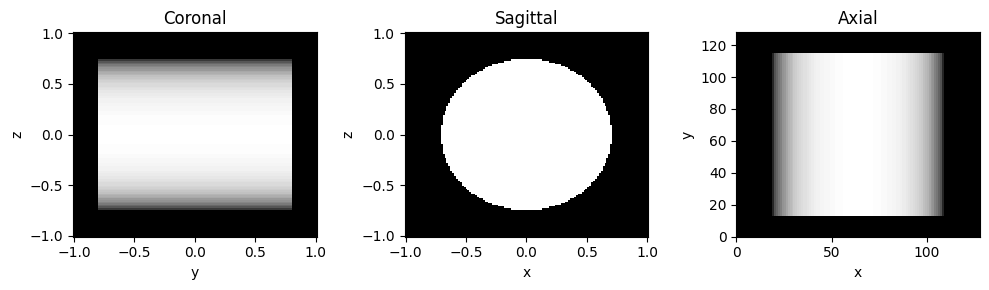

In [34]:
fig, _ = plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.pcolormesh(x,x,obj[0].sum(axis=0).T, cmap='Greys_r')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Coronal')
plt.subplot(132)
plt.pcolormesh(x,x,obj[0].sum(axis=1).T, cmap='Greys_r')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Sagittal')
plt.subplot(133)
plt.pcolormesh(obj[0].sum(axis=2).T, cmap='Greys_r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Axial')
fig.tight_layout()

# Fundamental Operations

Now that we have a 3D object $f$, we may want to turn this into projections $g$ using

$$g = Hf$$

Assuming no attenuation, PSF modeling, scattering, we can model this by projecting the object at different angles (think of it like taking an X-Ray at a number of different angles)

## Idea

Rotate the object first, always project along the x-axis

In [37]:
proj = obj.sum(axis=1)
proj.shape

torch.Size([1, 128, 128])

This is an projection

## The Rotate Function

The object is a tensor with 4 dimensions (including batch size). We can use the rotate function, which rotates the object in the $xy$-plane so long as $x$ and $y$ are the final two dimensions

* Right now $z$ is the last dimension

So we need to transpose the array then rotate

In [77]:
beta = 45
phi = 270 - beta
obj_rotated = rotate(obj.permute(0,3,1,2), -phi).permute(0,2,3,1)

We rotate by $-\phi$ so that the detector angle is $\phi$

In [53]:
proj_45 = obj_rotated.sum(axis=1)
proj_45.shape

torch.Size([1, 128, 128])

All this functionality is contained in the `rotate_detector_z` function [here](https://pytomography.readthedocs.io/en/latest/_modules/pytomography/utils/helper_functions.html#rotate_detector_z).

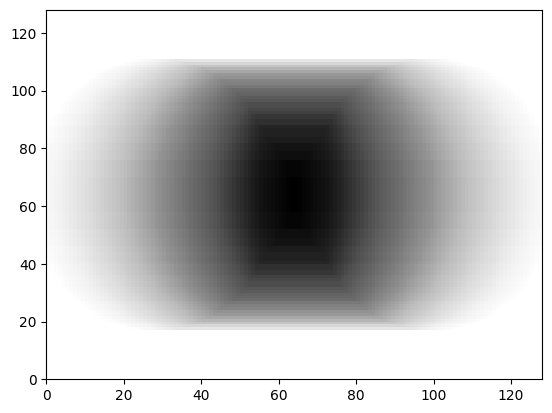

In [54]:
plt.pcolormesh(proj_45[0].T, cmap='Greys')

This is equivalent to what we would call $g_{45^{\circ}}$ in the SPECT example of the manual [here](https://pytomography.readthedocs.io/en/latest/notebooks/conventions.html#Mappings). We can the compute $g = \sum_{\theta} g_{\theta} \otimes \hat{\theta}$ by computing these projections for a number of angles

In [80]:
angles = np.arange(0,360.,3)

In [82]:
image = torch.zeros((1,len(angles),128,128))

In [84]:
image[:,2].shape

torch.Size([1, 128, 128])

In [85]:
for i,angle in enumerate(angles):
    object_i = rotate_detector_z(obj,angle)
    image[:,i] = object_i.sum(axis=1)

Now we can look at the image

Text(0, 0.5, 'r')

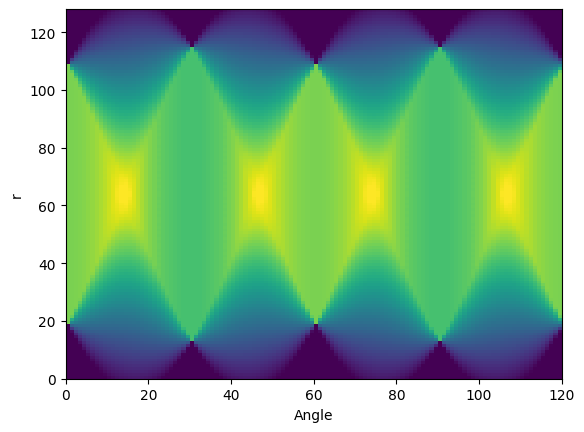

In [86]:
plt.pcolormesh(image[0,:,:,64].T)
plt.xlabel('Angle')
plt.ylabel('r')